# Fallen Angel Risk Premia

In [32]:
suppressWarnings(require("TTR"))
suppressWarnings(require("arrow"))
suppressWarnings(require("ggplot2"))
suppressWarnings(require("tidyverse"))

## Get Data

In [35]:
get_data <- function(){

    file_path <- (file.path(
        dirname(dirname(getwd())),
        "data",
        "RawData",
        "RawPrices.parquet"))
    
    df_out <- (read_parquet(
        file_path))

    return(df_out)
}

df_prices <- get_data()

In [37]:
df_prices %>% 
  select(date, security) %>% 
  group_by(security) %>% 
  filter(date == min(date) | date == max(date)) %>% 
  ungroup()

date,security
<date>,<chr>
2013-01-02,HYG
2013-07-01,JNK
2016-02-16,ANGL
2016-08-25,FALN
2024-10-29,HYG
2024-10-29,JNK
2024-10-29,FALN
2024-10-29,ANGL


## Exploratory Data Analysis

Cumulative Basis Points

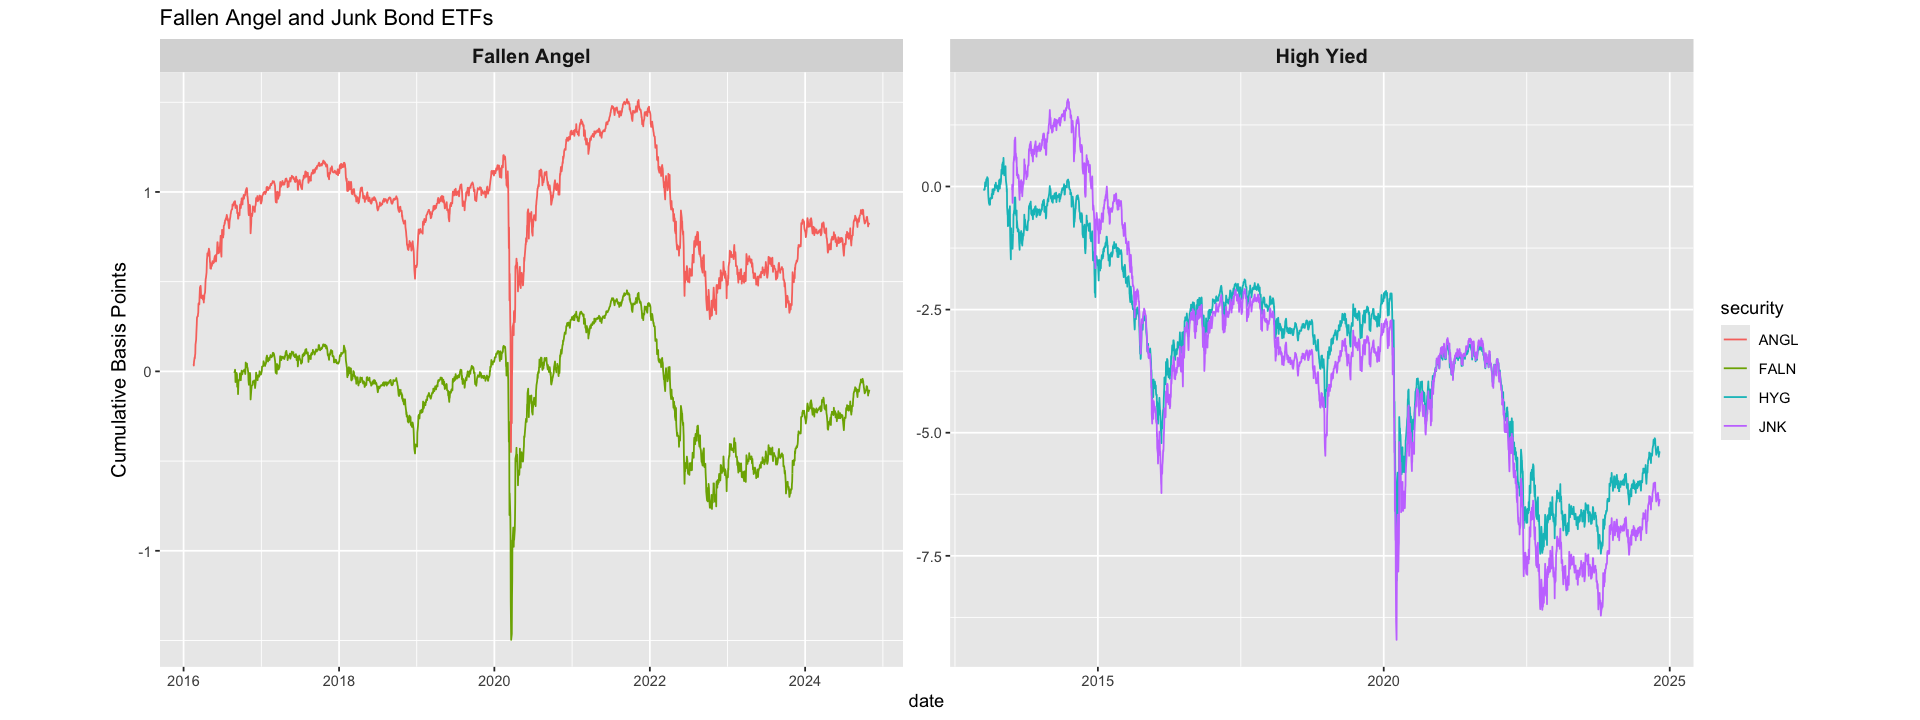

In [41]:
plot_rtns <- function(df_prices){

    options(repr.plot.width = 16, repr.plot.height = 6)
    
    df_prices %>% 
      select(security, date, PX_bps) %>% 
      drop_na() %>% 
      group_by(security) %>% 
      arrange(date) %>% 
      mutate(PX_bps = cumsum(PX_bps)) %>% 
      ungroup() %>% 
      mutate(sec_group = if_else(security %in% c("HYG", "JNK"), "High Yied", "Fallen Angel")) %>% 
      ggplot(aes(x = date, y = PX_bps, color = security)) +
      facet_wrap(~sec_group, scales = "free") +
      geom_line() +
      theme(aspect.ratio = 0.8) +
      labs(
          y     = "Cumulative Basis Points",
          title = "Fallen Angel and Junk Bond ETFs") +
      theme(
          strip.text   = element_text(size = 12, face = "bold"),
          axis.title.y = element_text(size = 12))
}
plot_rtns(df_prices)

Now comapre the duration

In [ ]:
plot_duration <- function(df_prices){
  
  df_prices %>% 
    select(security, date, mod_dur) %>% 
    mutate(sec_group = if_else(security %in% c("HYG", "JNK"), "High Yield", "Fallen Angel")) %>% 
    ggplot(aes(x = date, y = mod_dur, color = security)) +
    facet_wrap(~sec_group, scale = "free") +
    geom_line() +
    theme(aspect.ratio = 0.8) +
    labs(
      y = "Modified Duration (years)",
      title = "Fallen Angels and High Yield ETF Modified Duration (years)")
}

plot_duration(df_prices)

In this case the data can be a bit too noisy with outliers smoothning it out via 5d EWMA should work. 

In [44]:
smooth_duration <- function(df_prices, window){
  
  df_out <- df_prices %>% 
    select(date, security, mod_dur) %>% 
    drop_na() %>% 
    group_by(security) %>% 
    arrange(date) %>% 
    mutate(mod_dur = EMA(mod_dur, n = window)) %>% 
    ungroup() %>% 
    drop_na()
  
  return(df_out)
}

df_smooth <- smooth_duration(df_prices, 5)

In [ ]:
plot_duration(df_smooth)

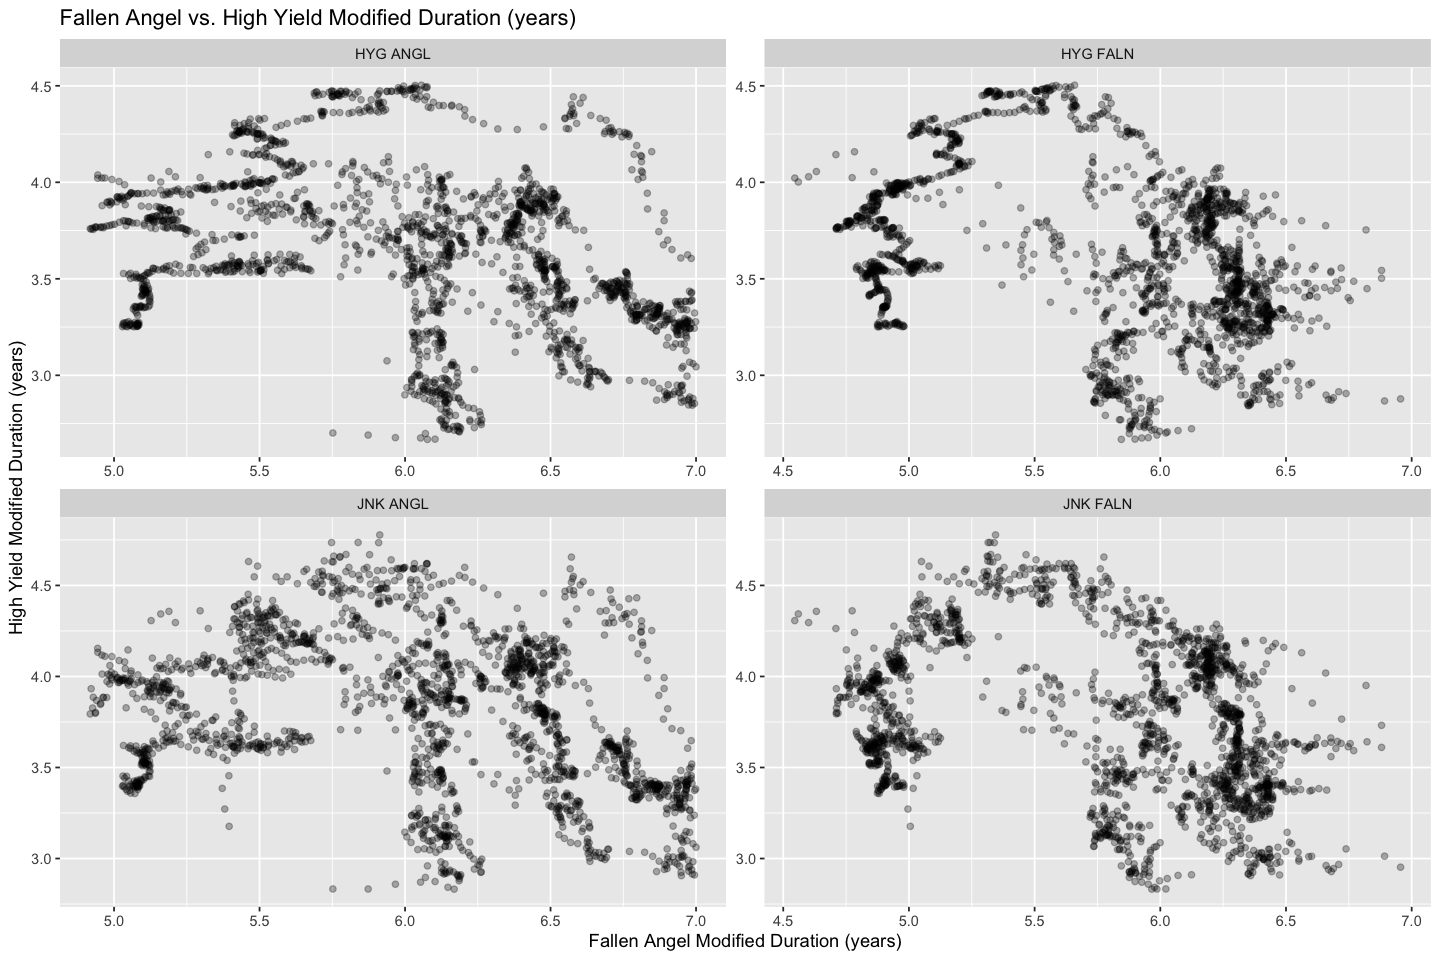

In [46]:
plot_duration_comparison <- function(df_smooth){

  options(repr.plot.width = 12, repr.plot.height = 8)
  df_hy <- df_smooth %>% 
    select(security, date, mod_dur) %>% 
    filter(security %in% c("HYG", "JNK")) %>% 
    rename(
      "hy_sec" = "security",
      "hy_dur" = "mod_dur")
  
  df_fa <- df_smooth %>% 
    select(security, date, mod_dur) %>% 
    filter(security %in% c("FALN", "ANGL")) %>% 
    rename(
      "fa_sec" = "security",
      "fa_dur" = "mod_dur") %>% 
    filter(fa_dur < 7)
  
  df_hy %>% 
    inner_join(df_fa, by = "date", relationship = "many-to-many") %>% 
    mutate(group_name = paste0(hy_sec, " ", fa_sec)) %>% 
    ggplot(aes(x = fa_dur, y = hy_dur)) +
    geom_point(alpha = 0.3) +
    facet_wrap(~group_name, scale = "free") +
    labs(
      x     = "Fallen Angel Modified Duration (years)",
      y     = "High Yield Modified Duration (years)",
      title = "Fallen Angel vs. High Yield Modified Duration (years)")
}

plot_duration_comparison(df_smooth)

## Simple Backtest

In [53]:
get_simple_backtest <- function(df_prices){
    
    df_hy <- df_prices %>% 
      select("hy_sec" = security, date, "hy_bps" = PX_bps) %>% 
      filter(hy_sec %in% c("HYG", "JNK"))
    
    df_fa <- df_prices %>% 
      select("fa_sec" = security, date, "fa_bps" = PX_bps) %>% 
      filter(fa_sec %in% c("ANGL", "FALN"))
    
    df_out <- df_hy %>% 
      inner_join(df_fa, by = c("date"), relationship = "many-to-many") %>% 
      drop_na() %>% 
      mutate(spread = fa_bps - hy_bps) %>% 
      group_by(hy_sec, fa_sec) %>% 
      mutate(cum_bps = cumsum(spread)) 

    return(df_out)
}

df_backtest <- get_simple_backtest(df_prices)

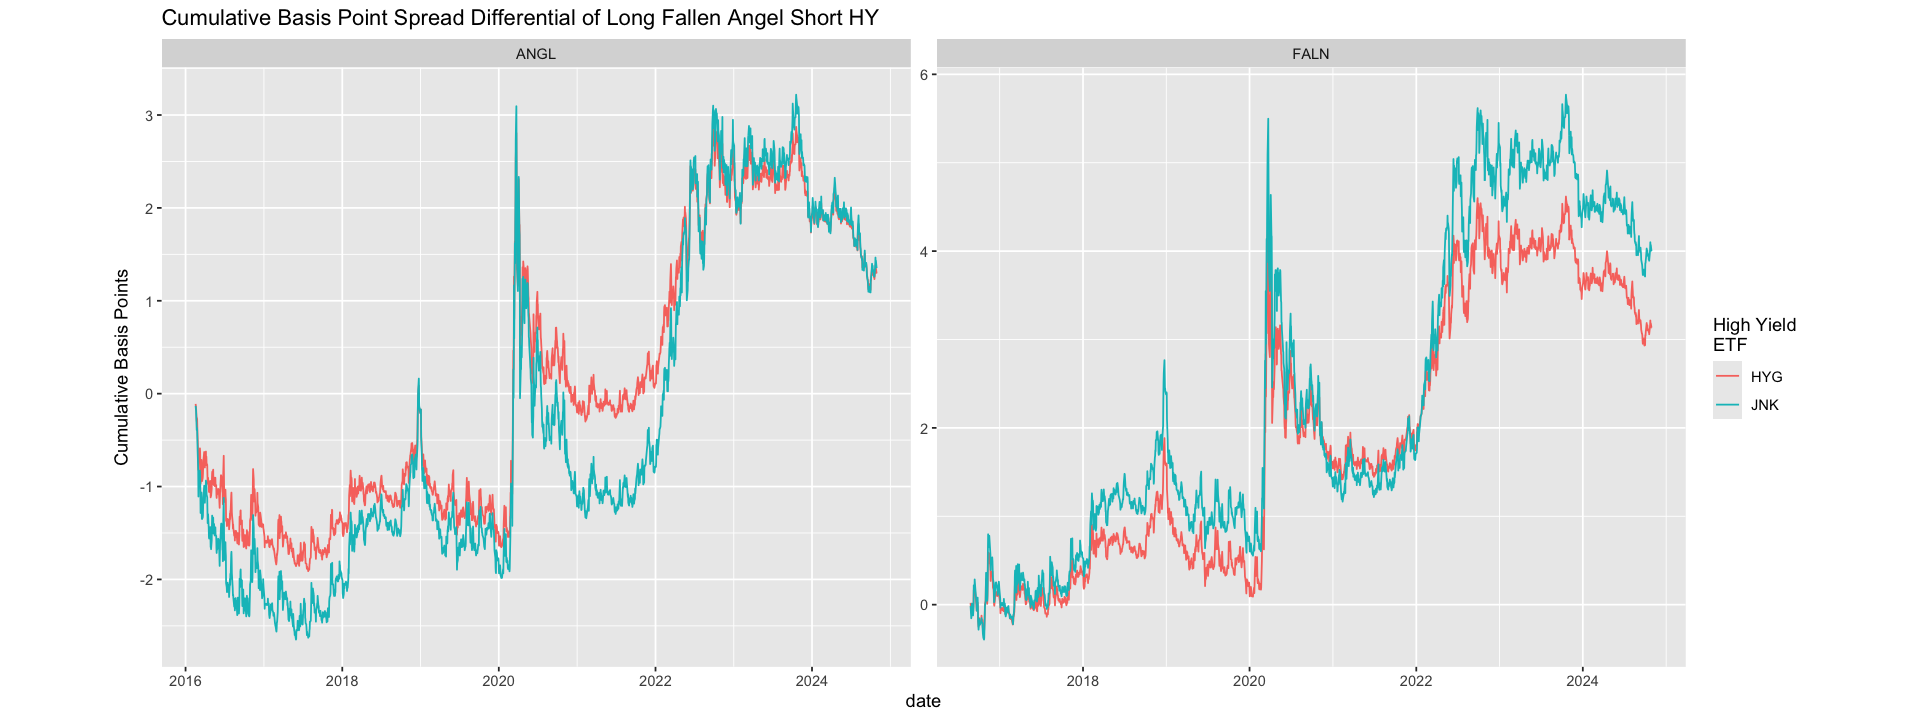

In [55]:
plot_backtest <- function(df_backtest){
    
    options(repr.plot.width = 16, repr.plot.height = 6)
    
    df_backtest %>% 
      ggplot(aes(x = date, y = cum_bps, color = hy_sec)) +
      facet_wrap(~fa_sec, scale = "free") + 
      geom_line() +
      theme(aspect.ratio = 0.8) + 
      labs(
        color = "High Yield\nETF",
        y     = "Cumulative Basis Points",
        title = "Cumulative Basis Point Spread Differential of Long Fallen Angel Short HY") 
}
plot_backtest(df_backtest)

In [56]:
get_backtest_sharpe <- function(df_backtest){
    
    df_sharpe <- df_backtest %>% 
      group_by(hy_sec, fa_sec) %>% 
      summarize(
        mean_rtn = mean(spread),
        std_rtn  = sd(spread)) %>% 
      ungroup() %>% 
      mutate(sharpe = mean_rtn / std_rtn * sqrt(252)) 

    return(df_sharpe)
}

df_sharpe <- get_backtest_sharpe(df_backtest)

`summarise()` has grouped output by 'hy_sec'. You can override using the `.groups` argument.


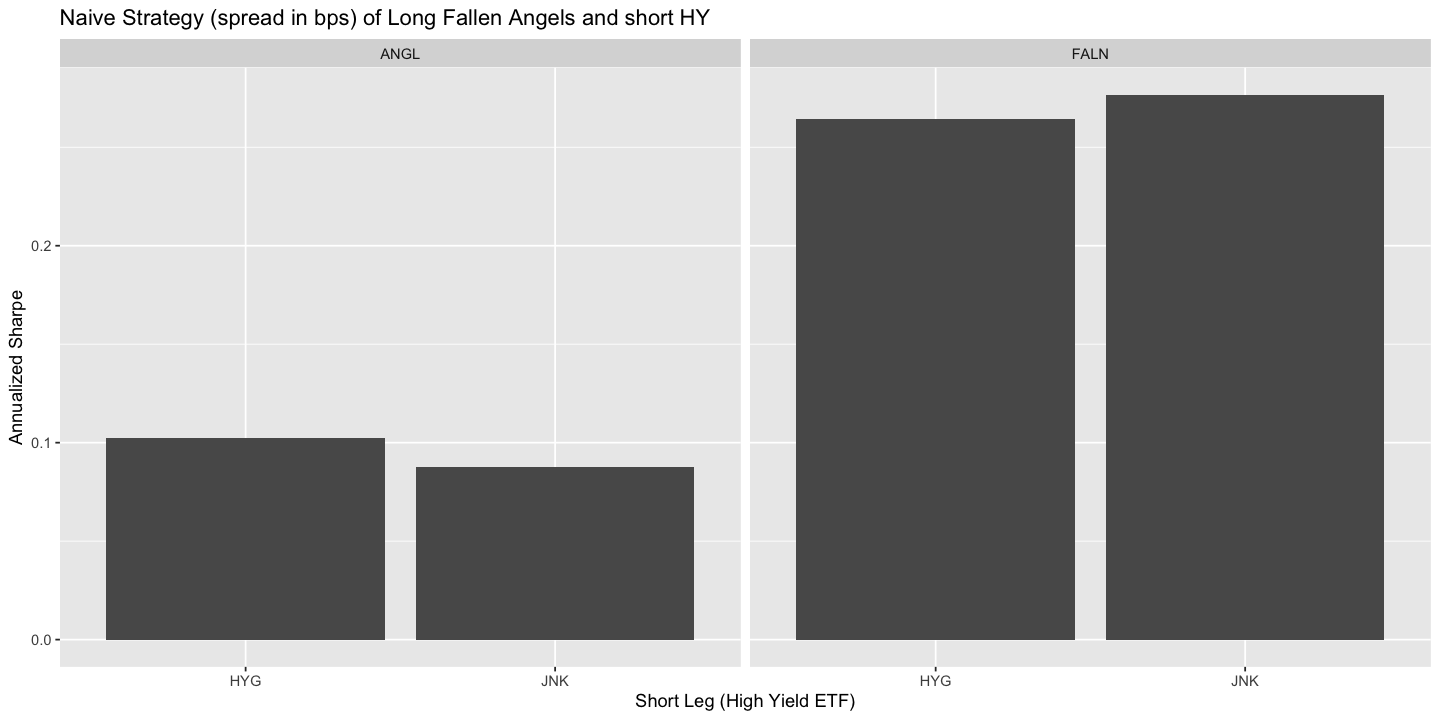

In [58]:
plot_naive_sharpe <- function(df_sharpe){

    options(repr.plot.width = 12, repr.plot.height = 6)

    df_sharpe %>% 
      ggplot(aes(x = hy_sec, y = sharpe, color)) +
      facet_wrap(~fa_sec, scale = "free_x") +
      geom_bar(stat = "identity") +
      labs(
        x     = "Short Leg (High Yield ETF)",
        y     = "Annualized Sharpe",
        title = "Naive Strategy (spread in bps) of Long Fallen Angels and short HY")
}
plot_naive_sharpe(df_sharpe)